<a href="https://colab.research.google.com/github/MithilaCoomaraswamy/DSGP/blob/Period-Tracker/Ovulation_Date.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
pip install pycaret

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from pycaret.regression import setup, create_model, compare_models, evaluate_model, save_model, predict_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [70]:
df = pd.read_csv('PeriodData.csv')
np.random.seed(42)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ClientID                    1665 non-null   object
 1   CycleNumber                 1665 non-null   int64 
 2   Group                       1665 non-null   int64 
 3   CycleWithPeakorNot          1665 non-null   int64 
 4   ReproductiveCategory        1665 non-null   int64 
 5   LengthofCycle               1665 non-null   int64 
 6   MeanCycleLength             1665 non-null   object
 7   EstimatedDayofOvulation     1665 non-null   object
 8   LengthofLutealPhase         1665 non-null   object
 9   FirstDayofHigh              1665 non-null   object
 10  TotalNumberofHighDays       1665 non-null   object
 11  TotalHighPostPeak           1665 non-null   object
 12  TotalNumberofPeakDays       1665 non-null   object
 13  TotalDaysofFertility        1665 non-null   obje

In [72]:
df = df[['ClientID', 'CycleNumber', 'LengthofCycle', 'MeanCycleLength',
       'EstimatedDayofOvulation', 'LengthofMenses', 'MeanMensesLength']]

In [73]:
df['MeanCycleLength'] = df.groupby('ClientID')['MeanCycleLength'].transform('first')
df['MeanMensesLength'] = df.groupby('ClientID')['MeanMensesLength'].transform('first')

In [74]:
def fill_missing_menses_length(df):
    # Group by ClientID to process each unique ClientID
    for client_id, group in df.groupby('ClientID'):
        # If 'MeanMensesLength' is missing (NaN), calculate the mean of 'LengthofMenses'
        if group['MeanMensesLength'].isnull().any():
            mean_menses_length = group['LengthofMenses'].mean()

            # Fill missing MeanMensesLength with the calculated mean
            df.loc[df['ClientID'] == client_id, 'MeanMensesLength'] = df.loc[df['ClientID'] == client_id, 'MeanMensesLength'].fillna(mean_menses_length)

    return df

In [75]:
df = fill_missing_menses_length(df)

In [76]:
def fill_missing_menses_length(df):
    # Group by ClientID to process each unique ClientID
    for client_id, group in df.groupby('ClientID'):
        # If 'MeanMensesLength' is missing (NaN), calculate the mean of 'LengthofMenses'
        if group['MeanMensesLength'].isnull().any():
            mean_menses_length = group['LengthofMenses'].mean()

            # Fill missing MeanMensesLength with the calculated mean
            df.loc[df['ClientID'] == client_id, 'MeanMensesLength'] = df.loc[df['ClientID'] == client_id, 'MeanMensesLength'].fillna(mean_menses_length)

    return df

In [77]:
df = fill_missing_menses_length(df)

In [78]:
def fill_missing_cycle_length(df):
    # Group by ClientID to process each unique ClientID
    for client_id, group in df.groupby('ClientID'):
        # If 'MeanCycleLength' is missing (NaN), calculate the mean of 'LengthofCycle'
        if group['MeanCycleLength'].isnull().any():
            mean_cycle_length = group['LengthofCycle'].mean()

            # Fill missing MeanCycleLength with the calculated mean
            df.loc[df['ClientID'] == client_id, 'MeanCycleLength'] = df.loc[df['ClientID'] == client_id, 'MeanCycleLength'].fillna(mean_cycle_length)

    return df

In [79]:
df = fill_missing_cycle_length(df)

In [80]:
def fill_missing_ovulation_day(df):
    # Loop through each unique ClientID and calculate mean Estimated Day of Ovulation
    for client_id, group in df.groupby('ClientID'):
        # Convert 'EstimatedDayofOvulation' to numeric before calculating the mean
        group['EstimatedDayofOvulation'] = pd.to_numeric(group['EstimatedDayofOvulation'], errors='coerce')

        # Calculate the mean of the existing EstimatedDayofOvulation values for this ClientID
        mean_ovulation_day = group['EstimatedDayofOvulation'].mean()

        # If the mean is not NaN, fill missing values with the mean for the current ClientID
        if not pd.isna(mean_ovulation_day):
            df.loc[df['ClientID'] == client_id, 'EstimatedDayofOvulation'] = df.loc[df['ClientID'] == client_id, 'EstimatedDayofOvulation'].fillna(mean_ovulation_day)

    return df

In [81]:
df = fill_missing_ovulation_day(df)

In [82]:
df = df[df['ClientID'] != 'nfp8085']

In [83]:
df = df[df['ClientID'] != 'nfp8226' ]

In [84]:
df.loc[:, 'LengthofMenses'] = df.groupby('ClientID')['LengthofMenses'].transform(lambda x: pd.to_numeric(x, errors='coerce').fillna(pd.to_numeric(x, errors='coerce').mean()))

In [85]:
rows_with_missing_values = df[df.isnull().any(axis=1)]
print(rows_with_missing_values)

Empty DataFrame
Columns: [ClientID, CycleNumber, LengthofCycle, MeanCycleLength, EstimatedDayofOvulation, LengthofMenses, MeanMensesLength]
Index: []


In [86]:
# Check for duplicate rows.
print(f"There are {df.duplicated().sum()} duplicate rows in the data set.")

# Remove duplicate rows.
df=df.drop_duplicates()
print("The duplicate rows were removed.")

There are 15 duplicate rows in the data set.
The duplicate rows were removed.


In [87]:
df = df.drop(columns=['ClientID'])

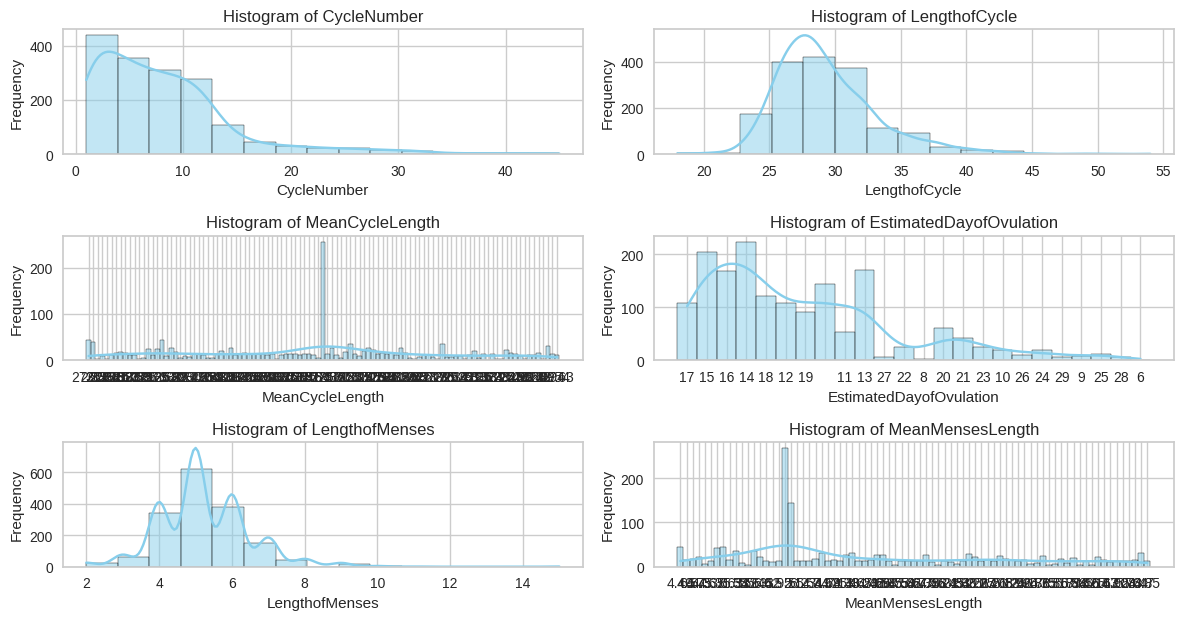

In [88]:
# Plot histograms
columns_to_plot = ['CycleNumber', 'LengthofCycle', 'MeanCycleLength',
       'EstimatedDayofOvulation', 'LengthofMenses','MeanMensesLength']

plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[column], bins=15, kde=True, color='skyblue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

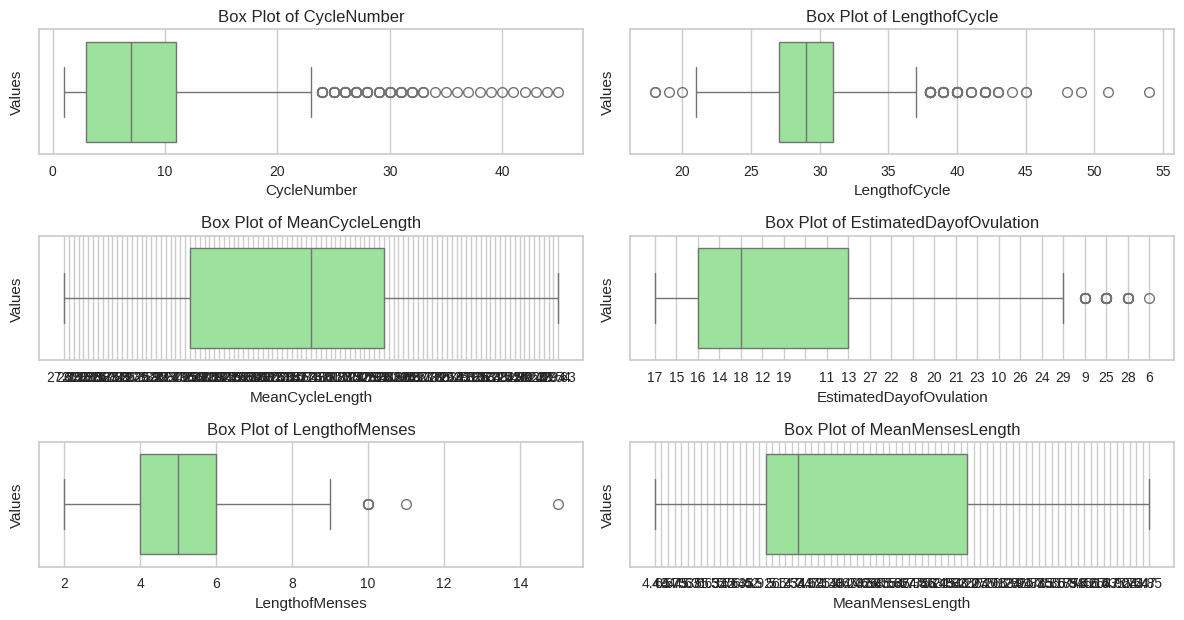

In [89]:
# Draw box plots to check for outliers
plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)  # 2 rows, 2 columns
    sns.boxplot(x=df[column], color='lightgreen')
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Values')

plt.tight_layout()

plt.show()

In [90]:
# Identify outliers using IQR
def handle_outliers(df, column):
    # Ensure the column is numeric before calculating quantiles
    df[column] = pd.to_numeric(df[column], errors='coerce')

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

for col in ['LengthofCycle', 'EstimatedDayofOvulation', 'LengthofMenses', 'MeanMensesLength', 'MeanCycleLength']:
    df = handle_outliers(df, col)

In [91]:
# Remove rows with missing values in 'EstimatedDayofOvulation'
df = df.dropna(subset=['EstimatedDayofOvulation'])

# Now proceed with PyCaret setup
from pycaret.regression import *

# Ensure 'EstimatedDayofOvulation' is numeric and not categorical.
# PyCaret might be mistaking it as categorical.
df['EstimatedDayofOvulation'] = pd.to_numeric(df['EstimatedDayofOvulation'], errors='coerce')

# Exclude 'EstimatedDayofOvulation' from numeric_features since it is the target
reg_setup = setup(data=df, target='EstimatedDayofOvulation')

# Compare regression models
best_model = compare_models()

# Create the best regression model
gb_model = create_model('gbr')
lgbm_model = create_model('lightgbm')
rf_model = create_model('rf')
xg_model = create_model('xgboost')


stacked_model = stack_models([lgbm_model, gb_model], meta_model=None)

# Evaluate the model
evaluate_model(stacked_model)

# Predict using the model on new data
predictions = predict_model(stacked_model, data=df)

# Save the model for future use
save_model(stacked_model, 'best_regression_model')

tuned_stacked_model = tune_model(stacked_model)
evaluate_model(tuned_stacked_model)

,Description,Value
0,Session id,6667
1,Target,EstimatedDayofOvulation
2,Target type,Regression
3,Original data shape,"(1503, 6)"
4,Transformed data shape,"(1503, 6)"
5,Transformed train set shape,"(1052, 6)"
6,Transformed test set shape,"(451, 6)"
7,Numeric features,5
8,Rows with missing values,16.4%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.3066,3.6161,1.8955,0.6503,0.1134,0.0861,0.1410
xgboost,Extreme Gradient Boosting,1.3311,3.8057,1.9386,0.6346,0.1163,0.0874,0.0780
gbr,Gradient Boosting Regressor,1.3608,3.7946,1.9415,0.6335,0.1166,0.0903,0.1110
rf,Random Forest Regressor,1.3656,3.9093,1.9681,0.6225,0.1171,0.0894,0.3120
et,Extra Trees Regressor,1.4488,4.1924,2.0365,0.5960,0.1219,0.0949,0.3380
lr,Linear Regression,1.5555,4.4693,2.1062,0.5668,0.1264,0.1027,1.5090
ridge,Ridge Regression,1.5556,4.4693,2.1062,0.5668,0.1264,0.1027,0.0210
lar,Least Angle Regression,1.5555,4.4693,2.1062,0.5668,0.1264,0.1027,0.0400
br,Bayesian Ridge,1.5574,4.4688,2.1062,0.5668,0.1264,0.1028,0.0230
huber,Huber Regressor,1.5302,4.5553,2.1247,0.5580,0.1278,0.1019,0.0430


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3997,3.7835,1.9451,0.6826,0.1098,0.0873
1,1.2421,3.6708,1.9159,0.5783,0.1161,0.0860
2,1.3206,3.3638,1.8341,0.6976,0.1016,0.0843
3,1.2353,3.4766,1.8646,0.6293,0.1148,0.0819
4,1.5814,5.2513,2.2916,0.5055,0.1345,0.1017
5,1.4369,4.0982,2.0244,0.6113,0.1259,0.0979
6,1.3428,3.2685,1.8079,0.6527,0.1092,0.0908
7,1.2670,3.2530,1.8036,0.6651,0.1086,0.0826
8,1.5535,4.6121,2.1476,0.6116,0.1345,0.1071


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3509,3.3779,1.8379,0.7166,0.1051,0.0848
1,1.1456,3.4762,1.8645,0.6006,0.1119,0.0781
2,1.3057,3.2560,1.8044,0.7073,0.1019,0.0821
3,1.3133,3.5452,1.8829,0.6220,0.1160,0.0856
4,1.5520,5.0197,2.2405,0.5273,0.1323,0.1003
5,1.2167,3.6301,1.9053,0.6557,0.1156,0.0828
6,1.2941,3.2033,1.7898,0.6596,0.1067,0.0861
7,1.2403,3.0867,1.7569,0.6822,0.1054,0.0805
8,1.5022,4.4781,2.1161,0.6229,0.1301,0.1029


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4127,3.8723,1.9678,0.6752,0.1122,0.0890
1,1.2543,4.0199,2.0050,0.5381,0.1187,0.0863
2,1.3518,3.3803,1.8386,0.6961,0.1032,0.0837
3,1.3431,3.4702,1.8629,0.6300,0.1136,0.0870
4,1.6606,5.6638,2.3799,0.4666,0.1367,0.1039
5,1.3204,3.5435,1.8824,0.6639,0.1140,0.0878
6,1.2413,3.1912,1.7864,0.6609,0.1070,0.0838
7,1.2609,3.4519,1.8579,0.6446,0.1121,0.0818
8,1.5824,5.1322,2.2654,0.5678,0.1385,0.1066


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4351,3.6967,1.9227,0.6899,0.1089,0.0892
1,1.1560,3.5521,1.8847,0.5919,0.1121,0.0792
2,1.3432,3.2701,1.8083,0.7060,0.1014,0.0834
3,1.2252,2.8562,1.6900,0.6955,0.1028,0.0780
4,1.5546,5.1896,2.2781,0.5113,0.1350,0.0990
5,1.3355,4.2002,2.0494,0.6016,0.1288,0.0936
6,1.2661,3.1675,1.7797,0.6634,0.1064,0.0848
7,1.2363,3.0782,1.7545,0.6831,0.1069,0.0806
8,1.5301,5.6638,2.3799,0.5231,0.1484,0.1028


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3401,3.4066,1.8457,0.7142,0.1048,0.0835
1,1.1539,3.4355,1.8535,0.6053,0.1117,0.0790
2,1.2665,3.0700,1.7521,0.7240,0.0984,0.0799
3,1.2670,3.3846,1.8397,0.6392,0.1132,0.0829
4,1.5433,4.9533,2.2256,0.5335,0.1315,0.0998
5,1.2416,3.5914,1.8951,0.6593,0.1167,0.0847
6,1.2623,3.0009,1.7323,0.6811,0.1041,0.0850
7,1.2006,3.0301,1.7407,0.6880,0.1049,0.0783
8,1.4738,4.3625,2.0887,0.6326,0.1298,0.1014


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,1.0408,2.3960,1.5479,0.7857,0.0945,0.0694


Transformation Pipeline and Model Successfully Saved


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3291,3.3586,1.8326,0.7183,0.1041,0.0828
1,1.1447,3.4341,1.8531,0.6055,0.1115,0.0783
2,1.2647,3.0897,1.7577,0.7222,0.0985,0.0797
3,1.2656,3.3933,1.8421,0.6382,0.1136,0.0829
4,1.5389,4.9547,2.2259,0.5334,0.1315,0.0995
5,1.2418,3.6009,1.8976,0.6584,0.1168,0.0847
6,1.2596,3.0027,1.7328,0.6810,0.1039,0.0847
7,1.2006,3.0300,1.7407,0.6880,0.1049,0.0783
8,1.4731,4.3607,2.0882,0.6328,0.1297,0.1014


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

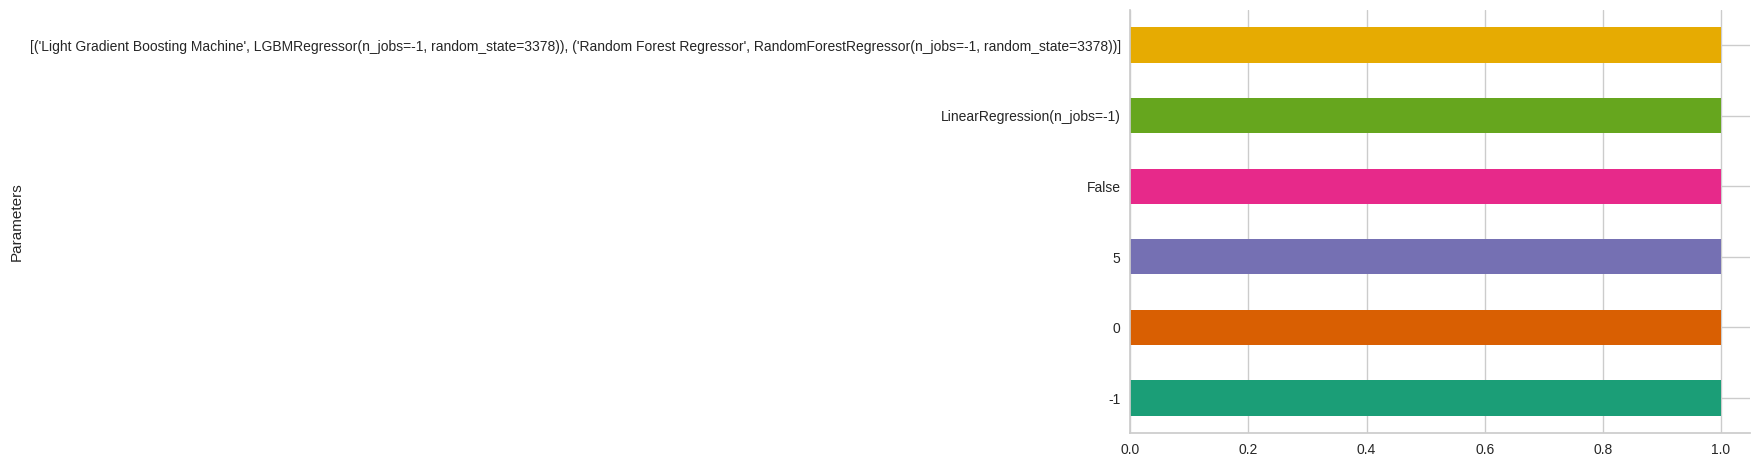

In [92]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Parameters').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

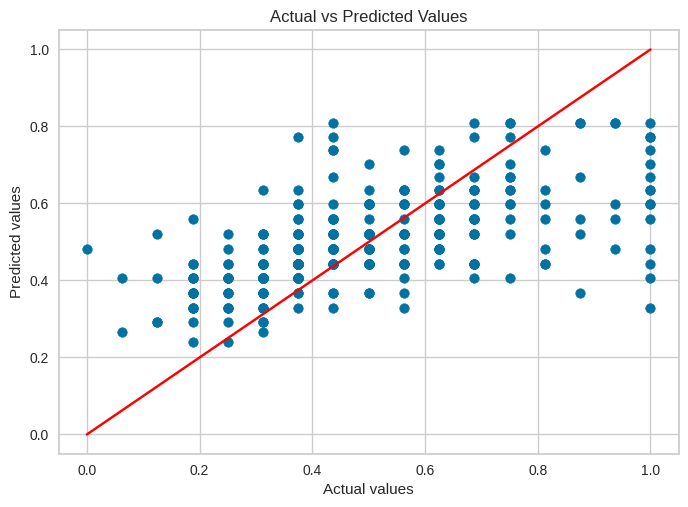

In [93]:
# Plotting the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Perfect prediction line
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted Values")
plt.show()

In [94]:
print(best_model)

LGBMRegressor(n_jobs=-1, random_state=6667)


In [95]:
scaler = MinMaxScaler(feature_range=(0, 1))

# For simplicity, we treat 'medv' as time series, though it's not the best choice for LSTM
scaled_data = scaler.fit_transform(df[['EstimatedDayofOvulation']].values)

# Reshape data to 3D: [samples, time steps, features]
def create_lstm_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_lstm_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# 2. Define LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=False, input_shape=(X.shape[1], 1)))
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Train the LSTM model
lstm_model.fit(X, y, epochs=10, batch_size=32)

# 4. Make predictions using the LSTM model
predictions_lstm = lstm_model.predict(X)

# Rescale predictions back to the original range
predictions_lstm_rescaled = scaler.inverse_transform(predictions_lstm)

# Save the LSTM model
lstm_model.save('lstm_model.h5')

# Print LSTM predictions (for demo purposes)
print(predictions_lstm_rescaled[:5])  # Show first 5 predictions

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0936
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0325
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0282
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0320
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0288
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0282
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0277
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0275
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0269
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0282
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[[15.755159]
 [15.327717]
 [15.494161]
 [15.351664]
 [15.504254]]


In [96]:
rmse = np.sqrt(mean_squared_error(y, predictions_lstm_rescaled))
mse = mean_squared_error(y, predictions_lstm_rescaled)
mae = mean_absolute_error(y, predictions_lstm_rescaled)
r2 = r2_score(y, predictions_lstm_rescaled)

# Print the performance metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

RMSE: 15.341663434756539
MAE: 15.235254342051038
MSE: 235.36663694534582
R²: -5373.520705434793


In [97]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Assuming 'df' is your dataframe and 'EstimatedDayofOvulation' is the target column

# Step 1: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['EstimatedDayofOvulation']].values)

# Define your features and target
X = scaled_data[:-1]  # All but the last value as features
y = scaled_data[1:]   # All but the first value as target (this is a time series prediction)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define the ANN Model
ann_model = Sequential()
ann_model.add(Dense(units=64, activation='relu', input_dim=1))  # Input layer
ann_model.add(Dense(units=32, activation='relu'))               # Hidden layer 1
ann_model.add(Dense(units=16, activation='relu'))               # Hidden layer 2
ann_model.add(Dense(units=1))                                  # Output layer

# Step 4: Compile the Model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model
ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Step 6: Make Predictions
y_pred = ann_model.predict(X_test)

# Step 7: Rescale predictions back to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Step 8: Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print performance metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

# Optionally, save the trained model
ann_model.save('ann_model.h5')


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1616 - val_loss: 0.0310
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301 - val_loss: 0.0314
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0278 - val_loss: 0.0305
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0269 - val_loss: 0.0306
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0311 - val_loss: 0.0305
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0289 - val_loss: 0.0313
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0262 - val_loss: 0.0319
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266 - val_loss: 0.0313
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0266 - val_loss: 0.0305
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289 - val_loss: 0.0309
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0272 - val_loss: 0.0319
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0285 - val_lo

RMSE: 2.807792560170072
MAE: 2.0641773578732514
MSE: 7.883699060946409
R²: 0.33806181433765914
